In [1]:
import pandas as pd

In [11]:
df = pd.read_csv("./data.csv")
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.y.value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [4]:
all_columns = df.columns
all_columns

Index(['Id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

## `EDA: ` Exploratory Data Analysis

### Drop Id Column

In [12]:
# Drop the id column as it is not required for now
print(f"Shape of dataset befor id removal: {df.shape}")
del df['Id']
print(f"Shape of dataset After id removal: {df.shape}")

Shape of dataset befor id removal: (45211, 18)
Shape of dataset After id removal: (45211, 17)


### Drop Null Values

In [14]:
df.isnull().sum()
print(f"Shape of dataset befor drop null values: {df.shape}")
total_rows = len(df.y)
df = df.dropna()
print(f"Shape of dataset after drop null values: {df.shape}")
print(f"Total number of rows contains null values: {total_rows - len(df.y)}")

Shape of dataset befor drop null values: (45211, 17)
Shape of dataset after drop null values: (45200, 17)


### Make feature list

In [17]:
target = 'y'
# create the list of categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"categorical_features : {categorical_features}")
# create the list of numerical features
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()
print(f"numerical_features : {numerical_features}")

categorical_features : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
numerical_features : ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


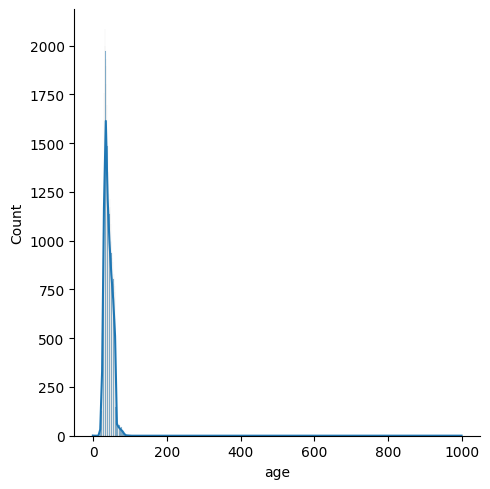

In [23]:
import seaborn as sns

sns.displot(df.age, kde=True)

In [27]:
# This is illogical or not possible value
df.age[df.age > 100].value_counts()

age
999.0    1
Name: count, dtype: int64

In [29]:
# Let's drop the illogical age value
df = df[df.age != 999.0]

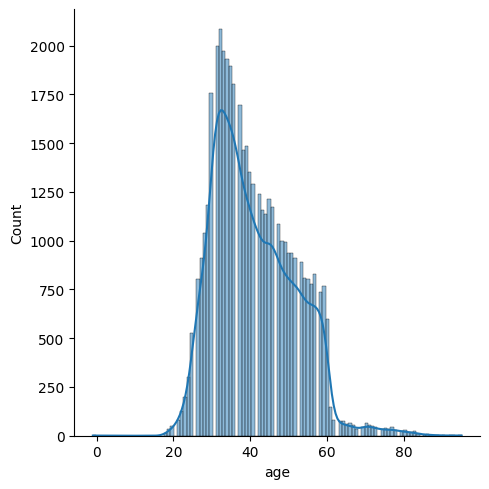

In [30]:
# After dropping the illogical Age Value
import seaborn as sns

sns.displot(df.age, kde=True)

### `Calculate mutual information of categorical variables`

In [31]:
from sklearn.metrics import mutual_info_score
scores = []
for col in categorical_features:
    score = mutual_info_score(df[target], df[col])
    scores.append(round(score, 4))
    print(f"{col} -> {round(score, 4)}")
print(f"Scores : {scores}")

job -> 0.0083
marital -> 0.0021
education -> 0.0026
default -> 0.0003
housing -> 0.0096
loan -> 0.0026
contact -> 0.0136
month -> 0.0243
poutcome -> 0.0294
y -> 0.3609
Scores : [0.0083, 0.0021, 0.0026, 0.0003, 0.0096, 0.0026, 0.0136, 0.0243, 0.0294, 0.3609]


In [32]:
import numpy as np

categorical_data = np.array(list(zip(categorical_features, scores)), dtype=[('category', 'U10'), ('value', float)])

# Sort the NumPy array by the 'value' field
sorted_data = np.sort(categorical_data, order='value')

# Convert the sorted NumPy array back to a list of tuples (optional)
sorted_list = sorted_data.tolist()

sorted_list

[('default', 0.0003),
 ('marital', 0.0021),
 ('education', 0.0026),
 ('loan', 0.0026),
 ('job', 0.0083),
 ('housing', 0.0096),
 ('contact', 0.0136),
 ('month', 0.0243),
 ('poutcome', 0.0294),
 ('y', 0.3609)]

### Here `default` feature looks like have very less value as compare to others
so lets drop it

In [35]:
del df['default']
categorical_features.remove('default')

print(f"categorical features : {categorical_features}")

categorical features : ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


### Convert target feature into numerical from categorical

In [39]:
df[target] = df[target].replace({'yes': 1, 'no': 0})
numerical_features = numerical_features + [target]
print(f"numerical_features : {numerical_features}")

numerical_features : ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']


### Find corelation between numerical features:

Text(0.5, 1.0, 'Correlation Heatmap')

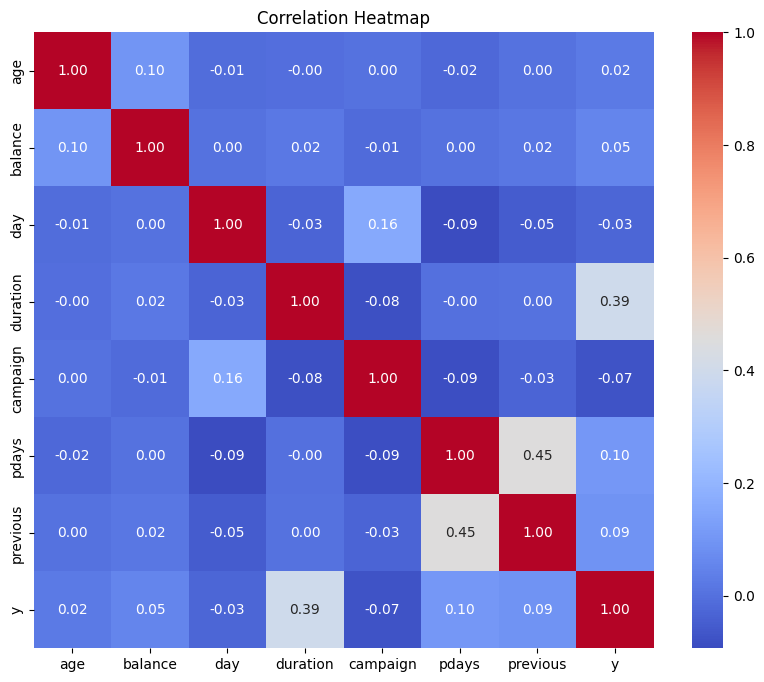

In [43]:
import matplotlib.pyplot as plt

import seaborn as sns

corr_matrix = df[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot= True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

### Split Data into Tran/Test/Val

In [44]:
from sklearn.model_selection import train_test_split

def split_data(df):    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

    print(f"train data size: {len(df_train)}, Test data size: {len(df_test)}, Validation data size: {len(df_val)}")

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return df_train, y_train, df_val, y_val, df_test, y_test

In [45]:
df_train, y_train, df_val, y_val, df_test, y_test = split_data(df)

train data size: 27119, Test data size: 9040, Validation data size: 9040


In [46]:
y_train.sum(), y_val.sum(), y_test.sum()

(3202, 1000, 1087)

### Add One Hot Encoding for categorical features

In [47]:
def prepare_dictionaries(df: pd.DataFrame):
    dicts = df.to_dict(orient='records')
    return dicts

dict_train = prepare_dictionaries(df_train)
dict_val = prepare_dictionaries(df_val)
dict_test = prepare_dictionaries(df_test)

In [48]:
dict_train[0]

{'age': 39.0,
 'job': 'housemaid',
 'marital': 'married',
 'education': 'tertiary',
 'balance': 315.0,
 'housing': 'no',
 'loan': 'no',
 'contact': 'cellular',
 'day': 28,
 'month': 'aug',
 'duration': 53,
 'campaign': 4,
 'pdays': -1,
 'previous': 0,
 'poutcome': 'unknown'}

## Train `LogisticRegression` Model

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

def get_train_pipeline(X, y):
    pipeline = make_pipeline(
        DictVectorizer(),
        LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    )
    pipeline.fit(X, y)
    return pipeline

pipeline = get_train_pipeline(dict_train, y_train)

### Model Evaluation

In [50]:
from sklearn.metrics import accuracy_score

def get_model_evaluation(pipeline, X, y):
    y_pred = pipeline.predict(X)
    acc = accuracy_score(y, y_pred)
    return round(acc, 4)

In [51]:
print(f"Model Evaluation on train data: {get_model_evaluation(pipeline, dict_train, y_train)}")
print(f"Model Evaluation on test data: {get_model_evaluation(pipeline, dict_test, y_test)}")
print(f"Model Evaluation on validation data: {get_model_evaluation(pipeline, dict_val, y_val)}")

Model Evaluation on train data: 0.9004
Model Evaluation on test data: 0.9058
Model Evaluation on validation data: 0.9022


## Save model in using `pickle`

In [53]:
import pickle
output_file = 'logistic_regression_model.bin'

def save_model(model, output_file):
    output_file_path = f'artifacts/{output_file}'
    with open(output_file_path,'wb') as f_out: 
        pickle.dump(model, f_out)
        
save_model(pipeline, output_file)

In [55]:
def load_model(model_file):
    model_file_path = f'artifacts/{model_file}'
    with open(model_file_path,'rb') as f_in: 
        return pickle.load(f_in)
    
model = load_model('logistic_regression_model.bin')

In [56]:
print(f"Model Evaluation on test data: {get_model_evaluation(model, dict_test, y_test)}")

Model Evaluation on test data: 0.9058


In [57]:
y_pred = pipeline.predict(dict_test)

In [58]:
list(zip(y_pred, y_test))[1:10]

[(0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]